<a href="https://colab.research.google.com/github/XueyanZhang/MachineLearningCompilation/blob/master/MLC_End_to_End_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T
from __future__ import annotations 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 MB 8.5 MB/s eta 0:00:00


# End to End Model

To showcase a simple image recognition neural network from end to end.
Transform from development form to deployment form.


## The Model

x: Tensor[(1, 784)] -> linear: Tensor[(1, 128)] -> relu -> linear: Tensor[(1, 10)]

In [2]:
# load dataset MNIST
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

100%|██████████| 26421880/26421880 [00:01<00:00, 17495630.01it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303988.81it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5549395.79it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5935205.33it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



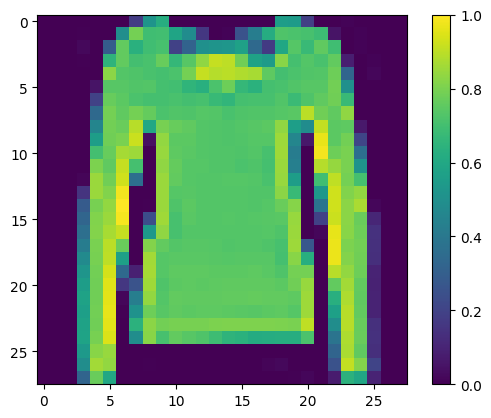

class: Pullover


In [3]:
# plot an image instance in dataset
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("class:", class_names[label[0]])

In [4]:
# download model parameters
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2023-04-30 01:15:12--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2023-04-30 01:15:12--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.03s   

2023-04-30 01:15:12 (11.2 MB/s) - ‘fasionmnist_mlp_params.p

## high level numpy version

In [5]:
# MLP: Multilayer perceptron
def np_mlp(data, w0, b0, w1, b1):
    out0 = data @ w0.T + b0
    out1 = np.maximum(out0, 0)
    out2 = out1 @ w1.T + b1
    return out2

In [6]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = np_mlp(img.reshape(1, 784),
             mlp_params["w0"],
             mlp_params["b0"],
             mlp_params["w1"],
             mlp_params["b1"])

print(res) # prediction score
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NP-MLP prediction:", class_names[pred_kind[0]]) # correct prediction

[[-22.240875   -5.735175   11.557992  -13.709605  -11.963933  -20.710833
  -15.99109   -41.71726    -7.2866316 -36.098503 ]]
[2]
NP-MLP prediction: Pullover


## low level numpy version

- use loop instead of array functions 
- explicitly allocate arrays. (manage preallocated memory access)
(aka, destination passing)

In [7]:
f32 = "float32"
def lnp_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, OUT: np.ndarray):
    Y = np.empty((1, 128), dtype=f32)
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k] # transpose
    for i in range(1):
        for j in range(128):
            OUT[i, j] = Y[i, j] + B[j]

def lnp_relu0(X: np.ndarray, OUT: np.ndarray):
    for i in range(1):
        for j in range(128):
            OUT[i, j] = np.maximum(X[i, j], 0)

def lnp_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, OUT: np.ndarray):
    Y = np.empty((1, 10), dtype=f32)
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k] # transpose
    for i in range(1):
        for j in range(10):
            OUT[i, j] = Y[i, j] + B[j]

def lnp_mlp(data, w0, b0, w1, b1):
    out0 = np.empty((1, 128), dtype=f32)
    lnp_linear0(data, w0, b0, out0)

    out1 = np.empty((1, 128), dtype=f32)
    lnp_relu0(out0, out1)

    out2 = np.empty((1, 10), dtype=f32)
    lnp_linear1(out1, w1, b1, out2)
    return out2

res = lnp_mlp(img.reshape(1, 784),
                 mlp_params["w0"],
                 mlp_params["b0"],
                 mlp_params["w1"],
                 mlp_params["b1"])
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NP-MLP prediction:", class_names[pred_kind[0]]) # correct again 

[2]
NP-MLP prediction: Pullover


## Tensor IR version

- destination passing: commonly used in low level lib designs, so high level framework can handle memory allocation decisions

In [8]:
@tvm.script.ir_module
class MyMLP:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), f32],
                W: T.Buffer[(128, 784), f32],
                B: T.Buffer[(128, ), f32],
                Z: T.Buffer[(1, 128), f32]):
        Y = T.alloc_buffer((1, 128))
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), f32],
                W: T.Buffer[(10, 128), f32],
                B: T.Buffer[(10, ), f32],
                Z: T.Buffer[(1, 10), f32]):
        Y = T.alloc_buffer((1, 10))
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n))
        Y = T.match_buffer(y, (1, n))
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @R.function
    def main(x: R.Tensor((1, "m"), dtype="float32"), 
             w0: R.Tensor(("n", "m"), dtype="float32"), 
             b0: R.Tensor(("n",), dtype="float32"), 
             w1: R.Tensor(("k", "n"), dtype="float32"), 
             b1: R.Tensor(("k",), dtype="float32")
             ) -> R.Tensor((1, "k"), dtype="float32"):
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_dps_packed("relu0", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_dps_packed("linear1", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

<ast>:3: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead
<ast>:4: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead
<ast>:5: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead
<ast>:6: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead
<ast>:20: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead
<ast>:21: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead
<ast>:22: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead
<ast>:23: DeprecationWarning: T.Buffer[...] is deprecated, use T.Buffer(...) instead


In [9]:
# build
ex = relax.build(MyMLP, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

In [10]:
# run
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)
pred_kind = np.argmax(nd_res.numpy(), axis=1)
# Tensor IR version shows the correct result
print("MyModule Prediction:", class_names[pred_kind[0]])

[[-22.240875  -5.735182  11.557992 -13.709604 -11.963931 -20.710833
  -15.991082 -41.71726   -7.286627 -36.098503]]
MyModule Prediction: Pullover


## Use Existing Libraries

Instead of implementing everything on our own, we could integrate existing libraries.

In [16]:
fp32 = "float32"

# IR module calling exisiting libraries
@tvm.script.ir_module
class MyMLPExternalCall:
    @R.function
    def main(x: R.Tensor((1, "m"), fp32),
             w0: R.Tensor(("n", "m"), fp32),
             b0: R.Tensor(("n",), fp32),
             w1: R.Tensor(("k", "n"), fp32),
             b1: R.Tensor(("k",), fp32)):
        m, n, k = T.int64(), T.int64(), T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("env.linear", (x, w0, b0), R.Tensor((1, n), f32))
            lv1 = R.call_dps_packed("env.relu", (lv0, ), R.Tensor((1, n), f32))
            out = R.call_dps_packed("env.linear", (lv1, w1, b1), R.Tensor((1, k), f32))
            R.output(out)
        return out

In [21]:
# register runtime func (we used above)
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    # convert tvm.nd.NDArray to torch tensor
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    # matrix mul
    torch.mm(x_torch, w_torch.T, out=out_torch)
    # add
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def torch_relu(x: tvm.nd.NDArray,
               out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

@tvm.register_func("env.relu_np", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_np = np.from_dlpack(x)
    out_np = np.from_dlpack(out)
    np.maximum(x_np, 0, out=out_np)

- DLPack: open in memory tensor structure for sharing tensors among frameworks.

In [22]:
# now with registered func above, ready to build and run
ex = relax.build(MyMLPExternalCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

# data_nd = tvm.nd.array(img.reshape(1, 784))
# nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyMLPExternalCall Prediction:", class_names[pred_kind[0]]) # correct result

MyMLPExternalCall Prediction: Pullover


We can also mix the use of existing library and TensorIR primitive functions.